Recognise Streetview Digits
=============


2. Data preprocessing
------------

- 2.1 Import modules and data
- 2.2 Visual check
- 2.3 Preprocess one sample
- 2.4 Preprocess all samples


**2.1 Import modules and data**

Start by reimporting all required modules.

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import random

import os
import sys
import tarfile

from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

Reload the pickled metadata.

In [2]:
def load_from_pickle(pickle_file):
  with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
  print('Metadata loaded from %s.' % pickle_file)
  return data

# train_folder = 'train'
# train_metadata = load_from_pickle('train_metadata.pickle')
# train_filenames, train_labels, train_boxes = train_metadata
# train_sample_count = len(train_filenames)

# test_folder  = 'test'
# test_metadata  = load_from_pickle('test_metadata.pickle')
# test_filenames,  test_labels,  test_boxes  = test_metadata
# test_sample_count  = len(test_filenames)

extra_folder = 'extra'
extra_metadata = load_from_pickle('extra_metadata.pickle')
extra_filenames, extra_labels, extra_boxes = extra_metadata
extra_sample_count  = len(extra_filenames)

Metadata loaded from extra_metadata.pickle.


Define the preprocessing modes

In [3]:
PREPROCESS_COLOUR_MODE = 'F'       # 'RGB' for colour, 'F' for greyscale (used in the report)
PREPROCESS_RESIZE_MODE = 'Stretch' # Either 'Stretch' or 'Pad' with random noise to keep aspect ratios (used in the report)

**2.2 Visual check**

Check the images and bounding boxes all look right

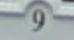

Image containing number: 9


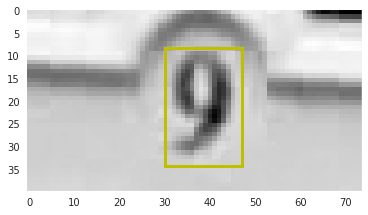

In [4]:
def label_to_text(label):
  num_digits = int(label[0])
  digits     = label[1:num_digits+1]
  digit_str  = ['0' if a==10 else str(int(a)) for a in digits]
  return ''.join(digit_str)

def read_image(folder, filename, quiet = False):
  image_file = os.path.join(folder,filename)
  image_data = ndimage.imread(image_file, mode=PREPROCESS_COLOUR_MODE).astype(float)
  if PREPROCESS_COLOUR_MODE != 'RGB': image_data = 255 - image_data
  if not quiet: display(Image(image_file))
  return image_data

def show_image(image, boxes=[]):
  if len(image.shape)>2 and image.shape[2]==1: image = image.reshape((image.shape[0], image.shape[1]))
  fig,ax = plt.subplots(1)
  ax.imshow(image, interpolation='none')
  colours = 'ybgrw'
  for i, box in enumerate(boxes):
    colour = colours[i % len(colours)]
    rectangle = patches.Rectangle((box['left'], box['top']), box['width'], box['height'],
                                  linewidth=3,edgecolor=colour,facecolor='none')
    ax.add_patch(rectangle)
  ax.grid(False)
  plt.show()

def show_samples(folder, filenames, boxes, labels, count):  
  for _ in range(count):
    sample = random.randrange(len(filenames))
    image  = read_image(folder, filenames[sample])
    bbox   = boxes.iloc[sample]
    print ("Image containing number: {}".format(label_to_text(labels[sample])))
    show_image(image, [bbox])

# show_samples(train_folder, train_filenames, train_boxes, train_labels, 1)
# show_samples(test_folder,  test_filenames,  test_boxes,  test_labels,  1)
show_samples(extra_folder, extra_filenames, extra_boxes, extra_labels, 1)

**2.3 Preprocess one sample**

Read the image and figure out where the square crop box needs to be. Create that box, fill it with image data and random noise where it goes outside the image boundary. Finally, resize to 64 x 64.

Image 2639, containing number 116


The cropped image


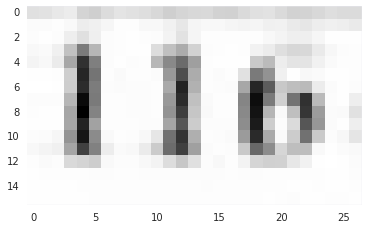

The final image


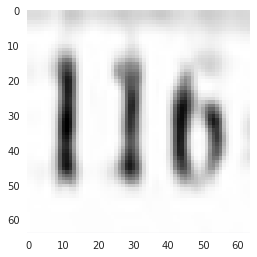

(64, 64, 1)


In [5]:
IMAGE_SIZE = 64
MARGIN     = 0.1
CHANNELS   = 3 if PREPROCESS_COLOUR_MODE == 'RGB' else 1

def make_box(top, left, height, width):
  return pd.Series([top, left, height, width], index=['top','left','height','width']).astype('int')

def define_crop_box(image_box, number_box):
  length = max(number_box['height'],number_box['width']) * (1 + MARGIN)  # take the longest side, add margin
  length = max(length, IMAGE_SIZE)                                 # don't let it be smaller than the target image size
  number_center_x = number_box['left'] + number_box['width']  / 2
  number_center_y = number_box['top']  + number_box['height'] / 2  
  crop_box = make_box(number_center_y - length / 2, number_center_x - length / 2, length, length)
  return crop_box

def get_corners(box):
  top, left     = box['top'], box['left']
  bottom, right = top + box['height'], left + box['width']
  return top, bottom, left, right

def get_overlap(box1, box2):
  top1, bottom1, left1, right1 = get_corners(box1)
  top2, bottom2, left2, right2 = get_corners(box2)
  top,  bottom = max(top1, top2),   min(bottom1, bottom2)
  left, right  = max(left1, left2), min(right1, right2)
  return make_box(top, left, bottom - top, right - left)

def crop_image(image, image_box, crop_box):
  c_top, c_bottom, c_left, c_right = get_corners(crop_box)
  image_overlap = get_overlap(image_box, crop_box)
  # pad with random pixel intensities if the crop is larger than the image 
  crop_overlap  = make_box(image_overlap['top'] - crop_box['top'],
                           image_overlap['left'] - crop_box['left'],
                           image_overlap['height'], image_overlap['width'])
  i_top, i_bottom, i_left, i_right = get_corners(image_overlap)
  c_top, c_bottom, c_left, c_right = get_corners(crop_overlap)
  if PREPROCESS_COLOUR_MODE == 'RGB':
    crop_image = 255 * np.random.rand(crop_box['height'],crop_box['width'],CHANNELS) 
    crop_image[c_top:c_bottom, c_left:c_right, :]  = image[i_top:i_bottom, i_left:i_right, :]
  else: 
    crop_image = 255 * np.random.rand(crop_box['height'],crop_box['width']) 
    crop_image[c_top:c_bottom, c_left:c_right]     = image[i_top:i_bottom, i_left:i_right]
  return crop_image

def resize(image):
  image = imresize(image, (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), interp='bicubic')
  if PREPROCESS_COLOUR_MODE != 'RGB':
    image = np.expand_dims(image, axis=2)
  return image

def stretch_to_fit(image, number_box, image_box):
  i_top, i_bottom, i_left, i_right = get_corners(image_box)
  nb     = number_box
  top    = int(max(i_top,    nb['top']  - (nb['height'] * MARGIN) // 2 ))
  bottom = int(min(i_bottom, nb['top']  + (nb['height'] * MARGIN) // 2 + nb['height'] ))
  left   = int(max(i_left,   nb['left'] - (nb['width']  * MARGIN) // 2 ))
  right  = int(min(i_right,  nb['left'] + (nb['width']  * MARGIN) // 2 + nb['width'] ))
  if PREPROCESS_COLOUR_MODE == 'RGB':
    cropped_image     = image[top:bottom, left:right, :]
  else: cropped_image = image[top:bottom, left:right]
  return cropped_image

def preprocess_sample(folder, filename, number_box, quiet=False):
  image = read_image(folder, filename, quiet)                # read the image into an array
  image_box = make_box(0, 0, image.shape[0], image.shape[1]) # get the coordinates of the overall image
  if PREPROCESS_RESIZE_MODE == 'Stretch':
    cropped_image = stretch_to_fit(image, number_box, image_box)
#     print(image.shape)
#     print(crop_box)
#     print(c_top, c_bottom, c_left, c_right)
#     print(crop_image.shape)
  else:
    crop_box = define_crop_box(image_box, number_box)          # figure out the coordinates of the crop box
    cropped_image = crop_image(image, image_box, crop_box)     # create the cropped image

  final_image   = resize(cropped_image)                        # resize to 64 x 64

  if not quiet: 
#     print("The image with bounding box")
#     show_image(image, [number_box])
#     print("The image with bounding and square crop box")
#     show_image(image, [number_box, crop_box])
    print("The cropped image")
    show_image(cropped_image)
    print("The final image")
    show_image(final_image)
    print(final_image.shape)
  return final_image

def show_preprocessed_samples(folder, filenames, boxes, labels, count):  
  for _ in range(count):
    sample = random.randrange(len(filenames))  # examples bigger than 64 x 64 for train data are 19613 and 29563
    bbox   = boxes.iloc[sample]
    print ("Image {}, containing number {}".format(sample, label_to_text(labels[sample])))
    preprocess_sample(folder, filenames[sample], bbox)

# show_preprocessed_samples(train_folder, train_filenames, train_boxes, train_labels, 1)
# show_preprocessed_samples(test_folder,  test_filenames,  test_boxes,  test_labels,  1)
show_preprocessed_samples(extra_folder, extra_filenames, extra_boxes, extra_labels, 1)

**2.4 Preprocess all samples**

Run the function on all the train and test data. Then subtract the mean and divide by the standard devation of all the pixel intensities. Check visually how the samples look, and finally pickle and save all train and test data and labels, ready for training in the next chapter.

In [9]:
def create_dataset(folder, filenames, boxes):
  num_samples = len(filenames)
  screen_width = 100
  dataset = np.zeros((num_samples, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype='float32')
  for i in range(num_samples):
    dataset[i,:,:,:] = preprocess_sample(folder, filenames[i], boxes.iloc[i], quiet = True)
    if i % (num_samples // screen_width)==0: print('.',end='')
  return dataset

# train_dataset = create_dataset(train_folder, train_filenames, train_boxes)
# print('\n',train_dataset.shape)
# test_dataset = create_dataset(test_folder, test_filenames, test_boxes)
# print('\n',test_dataset.shape)

# split the extra dataset into two as it's too big for my laptop
extra_1_size=1000
extra_dataset_1 = create_dataset(extra_folder, extra_filenames[:extra_1_size], extra_boxes[:extra_1_size])
print('\n',extra_dataset_1.shape)
# extra_dataset_2 = create_dataset(extra_folder, extra_filenames[extra_1_size:], extra_boxes[extra_1_size:])
# print('\n',extra_dataset_2.shape)


....................................................................................................
 (1000, 64, 64, 1)


In [10]:
def normalise(dataset):
  mean = np.mean(dataset)
  std = np.std(dataset)
  print('Mean: {} \nStd: {}'.format(mean, std))
  normalised_dataset = (dataset - mean) / std
  print('Mean: {} \nStd: {}'.format(np.mean(normalised_dataset), np.std(normalised_dataset)))
  return normalised_dataset

# train_dataset = normalise(train_dataset)
# test_dataset = normalise(test_dataset)
extra_dataset_1_norm = normalise(extra_dataset_1)
# extra_dataset_2 = normalise(extra_dataset_2)

Mean: 119.72694397 
Std: 72.3538208008
Mean: 2.73555514241e-07 
Std: 1.00000047684


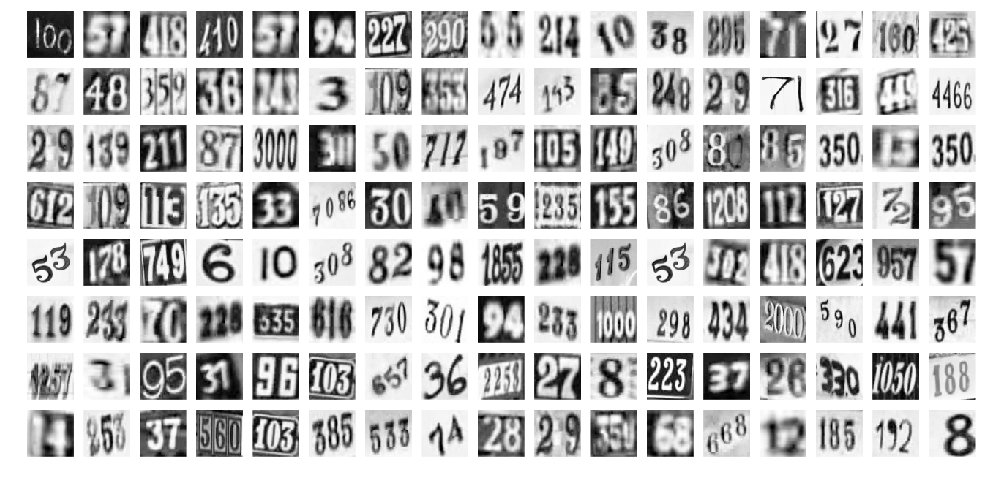

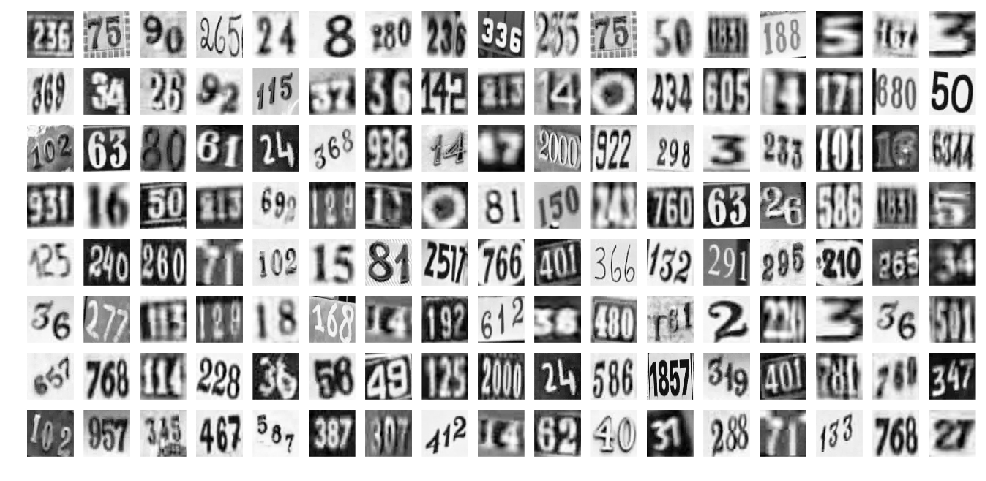

In [11]:
def show_grid_of_numbers(data, nrows=8, ncols=17):
  fig, ax_list = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,nrows))
  for i, ax in enumerate(ax_list.flat,start=1):
    image = data[random.randrange(data.shape[0])]
    if len(image.shape)>2 and image.shape[2]==1: image = image.reshape((image.shape[0], image.shape[1]))
    ax.imshow(image, interpolation='none')
    ax.grid(False)
    ax.axis('off')
  plt.show()

# show_grid_of_numbers(train_dataset)
# show_grid_of_numbers(test_dataset)
show_grid_of_numbers(extra_dataset_1)
show_grid_of_numbers(extra_dataset_1_norm)
# show_grid_of_numbers(extra_dataset_2)

What do we conclude after having investigated the two different possible pre-processing approaches?

1. **Forget RGB.** The images look horrible after normalisation. If we were going to use this, we'd have to find a better way to normalise. But intuitively, how often do we have images that are only differentiated by hue, not brightness? Surely, not often.
2. **Rather squish than pad.** This adds 5 percentage points of accuracy to the result (jumping from 87% to 92%). Aspect ratio is clearly not sacred in this dataset. The cost is less scale invariance, so we'd have to find a decent automated bounding box finder to deploy this in real life. 

In [117]:
def maybe_pickle(data, pickle_file, force=False):
  if os.path.exists(pickle_file) and not force:
    print('%s already present - Skipping pickling.' % pickle_file)
  else:
    print('Pickling %s.' % pickle_file)
    try:
      with open(pickle_file, 'wb') as f:  # wb means write and binary mode. returns an object of type file. 
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)

# maybe_pickle((train_dataset, train_labels),'train_data_preprocessed.pickle')
# maybe_pickle((test_dataset, test_labels),  'test_data_preprocessed.pickle')

extra_labels_1 = extra_labels[:extra_1_size]

maybe_pickle((extra_dataset_1, extra_labels_1),  'extra_data_preprocessed_1_RGB.pickle', force=True)
# maybe_pickle((extra_dataset_2, extra_labels_2),  'extra_data_preprocessed_2.pickle', force=True)

Pickling extra_data_preprocessed_1_stretch.pickle.
